# Define classes of metabolites

In [80]:
from libchebipy._chebi_entity import ChebiEntity
import os
import json

import reframed
import pandas as pd
import numpy as np

import collections

In [81]:
import sys
sys.path.append('../functions/')

import general_functions as general_func

### Load universal model

In [82]:
model_uni = reframed.load_cbmodel("../input/universe_bacteria.xml")

### Find the best way to map exchange to classes

#### Get Chebi ids associated with extracellular metabolites

In [83]:
chebi_ids = {}
#chebi_frac = {}

all_mets_chebi =[] 

for met in model_uni.metabolites:

    if model_uni.metabolites[met].compartment=="C_e":

        #ex_met.append(met)
        if "chebi" in model_uni.metabolites[met].metadata.keys():
            #chebi_in_met.append(met)
            all_mets_chebi.append(met)
            chebi_ids[met]=model_uni.metabolites[met].metadata["chebi"]
        else:
            chebi_ids[met]=None



In [84]:
len(all_mets_chebi)/len(chebi_ids.keys())

0.6791044776119403

**Find all chebi ids for the exchange reactions in all models (this also includes the ones that do not have chebi_id)**

In [87]:
super_dict = chebi_ids.copy()

In [91]:
super_dict["M_but_e"]= ['CHEBI:17968']
super_dict["M_ppa_e"] = ['CHEBI:17272']
super_dict["M_14glucan_e"]= ['CHEBI:15444']

super_dict["M_2h3mp_e"] = ['CHEBI:133085']
super_dict["M_2mba_e"] = ['CHEBI:37070']

super_dict["M_2mpa_e"] = ['CHEBI:16135']

super_dict["M_3mba_e"] =['CHEBI:28484']

super_dict["M_4abzglu_e"] =['CHEBI:60903']

super_dict["M_4hpro_DC_e"] =['CHEBI:16231']

super_dict["M_val__D_e"] =['CHEBI:27477']
super_dict["M_tyr__D_e"] = ['CHEBI:28479']

super_dict["M_leu__D_e"] = ['CHEBI:28225']
super_dict["M_isocap_e"] = ['CHEBI:74903'] # Annotated as isocaproate, but has no charge 

In [92]:
all_mets = [met[2:-2] for met in super_dict.keys()]
len(all_mets)

670

#### Get KEGG ids associated with extracellular metabolites

In [95]:
kegg_ids = {}
all_mets_kegg = []

   

for met in model_uni.metabolites:

    if model_uni.metabolites[met].compartment=="C_e":
        if "kegg.compound" in model_uni.metabolites[met].metadata.keys():
            all_mets_kegg.append(met)
            kegg_ids[met] = model_uni.metabolites[met].metadata["kegg.compound"]
        else:
            kegg_ids[met]=None

len(all_mets_kegg)/len(kegg_ids.keys())

0.6447761194029851

#### HMDB

In [98]:
HMDB_classes = pd.read_csv("../input/files_from_fairdomhub/bigg_classes.tsv",sep="\t")
HMDB_classes

,bigg,name,super_class,class,sub_class
0,thm,Thiamine,Organoheterocyclic compounds,Diazines,Pyrimidines and pyrimidine derivatives
1,26dap__M,"Meso-2,6-Diaminoheptanedioate",Organic acids and derivatives,Carboxylic acids and derivatives,"Amino acids, peptides, and analogues"
2,3cmp,3 CMP,"Nucleosides, nucleotides, and analogues",Ribonucleoside 3'-phosphates,Ribonucleoside 3'-phosphates
3,5mtr,5-Methylthio-D-ribose,Organooxygen compounds,Carbohydrates and carbohydrate conjugates,Sugar acids and derivatives
4,chols,Choline sulfate,Homogeneous non-metal compounds,Non-metal oxoanionic compounds,Non-metal sulfates
...,...,...,...,...,...
1611,xylnact__D,"D-Xylono-1,5-lactone",Organoheterocyclic compounds,Lactones,Delta valerolactones
1612,xylu__D,D-Xylulose,Organooxygen compounds,Carbohydrates and carbohydrate conjugates,Monosaccharides
1613,xylu__L,L-Threo-2-pentulose,Organic oxygen compounds,Organooxygen compounds,Carbohydrates and carbohydrate conjugates
1614,zeax,Zeaxanthin,Lipids and lipid-like molecules,Prenol lipids,Tetraterpenoids


In [99]:
HMDB_classes[HMDB_classes["bigg"].isin(all_mets)]["sub_class"].dropna().size/len(all_mets)

0.5447761194029851

### Overlap

In [100]:
chebi_mets = set([met[2:-2] for met in all_mets_chebi])
kegg_mets = set([met[2:-2] for met in all_mets_kegg])
hmdb_mets = set(HMDB_classes[HMDB_classes["bigg"].isin(all_mets)].bigg.values)

In [101]:
import matplotlib_venn as venn

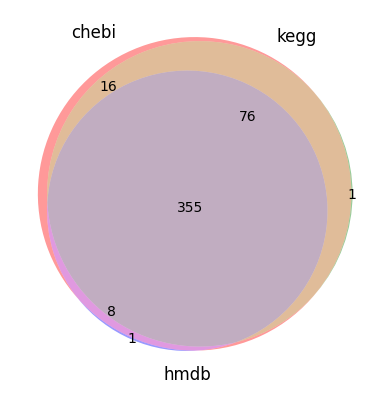

In [102]:
fig =venn.venn3([chebi_mets,kegg_mets,hmdb_mets],["chebi","kegg","hmdb"])

## Define substrate classes based on ChEBI

It's necessary to define some classes from CHEBI that we are interested in. 

Strategy:

- Define main classes. NB: Some compounds might fit into several classes
    - Define a hierarchy to avoid placing some compounds in a general class
    - Find the chebi class by recursively walking through the map.

In [103]:
really_large_classes = collections.OrderedDict({## Really Bigg classes
                "organonitrogen compounds":{
                    "CHEBI:35352":"organonitrogen compound"},
                "organosulfur compounds":{
                    "CHEBI:33261":"organosulfur compound"}, # from thiol CHEBI:29256
                "organophosphorus compounds":{
                    "CHEBI:25710":"organophosphorus compound"},
                "carboxylic acids and anions":{
                    "CHEBI:29067":"carboxylic acid anion",
                    "CHEBI:33575":"carboxylic acid"},
                "carbohydrate derivatives":{
                    "CHEBI:63299":"carbohydrate derivative"}
    })
large_classes = collections.OrderedDict({
                ## Bigg classes
                "alcohols and aldehydes":{
                    "CHEBI:15734": "primary alcohol",
                    "CHEBI:35681":"secondary alcohol",
                    "CHEBI:17478":"aldehyde"},


                "oligosaccharides":{
                    "CHEBI:50699":"oligosaccharide (undefined)"},
#                "lipid":{
#                    "CHEBI:18059":"lipid"
#                },
                "cofactors":{
                    "CHEBI:23357":"cofactor",
                    "CHEBI:33892":"iron coordination entity"}
                #"cofactors":{} #"CHEBI:5975":"iron chelate"
})
medium_classes = collections.OrderedDict({
                "aromatic compounds":{
                    "CHEBI:26195":"polyphenol"
                },
                "alkaloids":{
                    "CHEBI:22315":"alkaloid"
                },
                "polyamine":{
                    "CHEBI:88061":"polyamine"
                },
                "lipids":{
                    "CHEBI:16247":"phospholipid"},
                "steroid":{
                    "CHEBI:35341":"steroid"
                },
                "gases":{
                    "CHEBI:138675":"gas molecular entity"}
                
})

main_classes = collections.OrderedDict({
                "amino acids and derivatives":{
                    "CHEBI:37022":"amino-acid anion",
                    "CHEBI:33709":"amino acid",
                    "CHEBI:83821":"amino acid derivative"
},
                "oligopeptides":{                    
                    "CHEBI:25676":"oligopeptide"},
    
                "fatty acids":{
                    "CHEBI:58954":"straight-chain saturated fatty acid anion",
                    "CHEBI:58956":"branched-chain saturated fatty acid anion"},


                "carboxylic acids and anions":{
                    "CHEBI:33576":"sulfur-containing carboxylic acid"}, #From M_sulfac_e

                ## Carbohydrates
                "simple sugars":{
                    "CHEBI:35381":"monosaccharide",
                    "CHEBI:36233": "disaccharide"},
                "carbohydrate derivatives":{
                    "CHEBI:23639":"deoxy sugar",
                    "CHEBI:33720":"carbohydrate acid",# From M_galctn__L_e 
                },
                "oligosaccharides":{
                    "CHEBI:22590":"arabinan",
                    "CHEBI:37163":"glucan (undefined)"},
                "nucleotides and derivatives":{
                    "CHEBI:18282":"nucleobase", # From ura
                    "CHEBI:33838":"nucleoside",
                    "CHEBI:26401":"purines",
                    "CHEBI:39447":"pyrimidines",
                    "CHEBI:25608":"nucleoside phosphate"},
                    #"CHEBI:35241":"nucleotide-sugar",
                "B-vitamins":{
                   "CHEBI:75769": "B vitamin"},

                "other vitamins":{"CHEBI:12777":"vitamin A",
                                 "CHEBI:33234":"vitamin E",
                                 "CHEBI:27300":"vitamin D",
                                 "CHEBI:176783":"vitamin C",
                                 "CHEBI:28384":"vitamin K"},
                "inorganic ions and atoms":{
                    "CHEBI:24835":"inorganic ion",
                    "CHEBI:25585": "nonmetal atom"},

             
                "urea and urea derivatives":{
                    "CHEBI:47857":"ureas",
                    "CHEBI:16199":"urea"},
    
                "aromatic compounds":{
                    "CHEBI:33853":"phenols",
                    "CHEBI:27338": "xylene",
                    "CHEBI:27024":"toluenes"}, # From M_tol_e
                "other":{
                    "CHEBI:26191":"polyol",
                    "CHEBI:23217": "cholines",
                    "CHEBI:24828": "indoles",
                    "CHEBI:26188":"polyketide"} # Based on ttrcyc

               })

**Recursive function to find first parent matching with main classes**

In [104]:
def find_main_class(chebi_id, main_classes):
    # If chebi_id is the id of a  main class -> return value
    if chebi_id in main_classes:
        return chebi_id  

    entity = ChebiEntity(chebi_id)
    parents = [rel.get_target_chebi_id() for rel in entity.get_outgoings() if rel.get_type() == "is_a"]
    
    # If we have reached the end of the graph
    if len(parents)==0:
        return None
    
    
    for parent in parents:
        result = find_main_class(parent, main_classes)  
        if result is not None:
            return result  

    return None

In [105]:
met_chebi_dict = {} # previously called main_class_dict

for main_class_dict_nested in [main_classes,medium_classes,large_classes,really_large_classes]:
    main_class_dict = collections.OrderedDict()
    for d in main_class_dict_nested.values():
        for k, v in d.items():  
            main_class_dict[k]=v
    
    for met_id,chebi_list in super_dict.items():
        if chebi_list is None:
            continue
        
        if met_id in met_chebi_dict.keys():
            continue

        for chebi_id in chebi_list:
            main_class = find_main_class(chebi_id,main_class_dict.keys())
            if main_class is not None:
                met_chebi_dict[met_id]=main_class
                break

#### Define class chebi ids for new metabolites

In [106]:
iIB746 = reframed.load_cbmodel("../input/curated_models/iIB746.xml") # Make sure that this is up to date!

In [107]:
xylo_gluc = [rxn for rxn in iIB746.get_exchange_reactions() if "Q" in rxn and rxn.split("_")[2].isupper()]
ara_xyl = [rxn for rxn in iIB746.get_exchange_reactions() if "A" in rxn and rxn.split("_")[2].isupper()]

cellulose = [rxn for rxn in iIB746.get_exchange_reactions() if "cell" in rxn]
cellulose.append("R_EX_cell6_e")

xylan = [rxn for rxn in iIB746.get_exchange_reactions() if "xyla" in rxn]

new_classes_rxns = {"CHEBI:18233":xylo_gluc,"CHEBI:28427":ara_xyl,"CHEBI:3523":cellulose,"CHEBI:60938":xylan}

new_classes = {"oligosaccharides":{"CHEBI:60938":"glucuronoxylan","CHEBI:28427":"arabinoxylan","CHEBI:18233":"xyloglucan","CHEBI:3523":"cellodextrin"}}

In [108]:
for chebi_id,rxns in new_classes_rxns.items():
    for rxn in rxns:
        met_id = rxn.replace("R_EX_","M_")
        met_id = met_id.replace("EX_","M_")
        met_chebi_dict[met_id]=chebi_id

In [109]:
len(met_chebi_dict.keys())

476

In [110]:
len(super_dict.keys())

670

In [111]:
len(super_dict.keys())-len(met_chebi_dict.keys())

194

In [112]:
set(super_dict.keys())-set(met_chebi_dict.keys())

{'M_12dgr160_e',
 'M_12dgr180_e',
 'M_13dampp_e',
 'M_1ag160_e',
 'M_1ag180_e',
 'M_1ag181d9_e',
 'M_1ag182d9d12_e',
 'M_23dhbzs3_e',
 'M_2h3mb_e',
 'M_2m35mdntha_e',
 'M_34dhphe_e',
 'M_35dnta_e',
 'M_3h4atb_e',
 'M_4hphac_e',
 'M_4hptn_e',
 'M_4oxptn_e',
 'M_6atha_e',
 'M_LalaDgluMdapDala_e',
 'M_LalaDgluMdap_e',
 'M_R3hdec4e_e',
 'M_R_3h4atba_e',
 'M_R_3h6atha_e',
 'M_R_3hcmrs7e_e',
 'M_R_3hdcaa_e',
 'M_R_3hdd5ea_e',
 'M_R_3hdd6e_e',
 'M_R_3hdda_e',
 'M_R_3hhdca_e',
 'M_R_3hhpa_e',
 'M_R_3hhxa_e',
 'M_R_3hnonaa_e',
 'M_R_3hocta_e',
 'M_R_3hpba_e',
 'M_R_3hpdeca_e',
 'M_R_3hphpa_e',
 'M_R_3hphxa_e',
 'M_R_3hpnona_e',
 'M_R_3hpocta_e',
 'M_R_3hppta_e',
 'M_R_3hpt_e',
 'M_R_3htd58e_e',
 'M_R_3htd5e_e',
 'M_R_3httdca_e',
 'M_abg4_e',
 'M_acetone_e',
 'M_acysbmn_e',
 'M_airs_e',
 'M_ala_L_glu__L_e',
 'M_ala_L_thr__L_e',
 'M_ala_gln_e',
 'M_ala_his_e',
 'M_ala_leu_e',
 'M_alagly_e',
 'M_alahis_e',
 'M_alaleu_e',
 'M_alathr_e',
 'M_alatrp_e',
 'M_algac_MG_14_e',
 'M_algac_MG_23_e',
 'M_alg

**Coverage of all external metabolites in our model**

In [113]:
len(met_chebi_dict.keys())/len(super_dict.keys())

0.7104477611940299

#### Combine data as dataframe

**First we need a dict to map chebi id to class and the self defined super class**

In [114]:
chebi_classes = collections.defaultdict(set)

for class_dict in [medium_classes,large_classes,really_large_classes,main_classes,new_classes]:
    for met_super_class_name,sub_class_dict in class_dict.items():
        
        for chebi_id, chebi_class_name in sub_class_dict.items():  

            chebi_classes[chebi_id]={"chebi class":chebi_class_name,"self defined super class":met_super_class_name}

**Make a df for all the metabolites we were able to classify**

In [115]:
met_chebi_df = pd.DataFrame(met_chebi_dict.values(),index=met_chebi_dict.keys())
met_chebi_df.columns=["chebi id"]

**Combine data**

In [116]:
met_chebi_df["chebi class"]=met_chebi_df["chebi id"].map(lambda x:chebi_classes[x]["chebi class"])
met_chebi_df["self defined super class"]=met_chebi_df["chebi id"].map(lambda x:chebi_classes[x]["self defined super class"])

In [117]:
met_chebi_df

,chebi id,chebi class,self defined super class
M_12ppd__R_e,CHEBI:26191,polyol,other
M_12ppd__S_e,CHEBI:26191,polyol,other
M_13ppd_e,CHEBI:26191,polyol,other
M_14glucan_e,CHEBI:37163,glucan (undefined),oligosaccharides
M_23camp_e,CHEBI:25608,nucleoside phosphate,nucleotides and derivatives
...,...,...,...
M_cell4_e,CHEBI:3523,cellodextrin,oligosaccharides
M_cell3_e,CHEBI:3523,cellodextrin,oligosaccharides
M_cell6_e,CHEBI:3523,cellodextrin,oligosaccharides
M_xylan4_e,CHEBI:60938,glucuronoxylan,oligosaccharides


In [123]:
met_chebi_df

,chebi id,chebi class,self defined super class
M_12ppd__R_e,CHEBI:26191,polyol,other
M_12ppd__S_e,CHEBI:26191,polyol,other
M_13ppd_e,CHEBI:26191,polyol,other
M_14glucan_e,CHEBI:37163,glucan (undefined),oligosaccharides
M_23camp_e,CHEBI:25608,nucleoside phosphate,nucleotides and derivatives
...,...,...,...
M_cell4_e,CHEBI:3523,cellodextrin,oligosaccharides
M_cell3_e,CHEBI:3523,cellodextrin,oligosaccharides
M_cell6_e,CHEBI:3523,cellodextrin,oligosaccharides
M_xylan4_e,CHEBI:60938,glucuronoxylan,oligosaccharides


**Add remaining compounds into 'other'**

In [132]:
not_in_chebi = [met for met in super_dict.keys() if met not in met_chebi_df.index.values ]

for met in not_in_chebi:
    met_chebi_df.loc[met] = [None, "not classified", "other"]

### Overview

In [134]:
met_chebi_df["self defined super class"].value_counts()

self defined super class
other                          217
amino acids and derivatives     70
nucleotides and derivatives     57
carboxylic acids and anions     51
inorganic ions and atoms        43
carbohydrate derivatives        40
oligosaccharides                29
aromatic compounds              28
simple sugars                   25
alcohols and aldehydes          21
organophosphorus compounds      18
organonitrogen compounds        13
oligopeptides                   11
organosulfur compounds          10
B-vitamins                       7
fatty acids                      7
cofactors                        6
urea and urea derivatives        4
polyamine                        4
lipids                           3
steroid                          2
gases                            2
alkaloids                        1
other vitamins                   1
Name: count, dtype: int64

In [135]:
met_chebi_df[met_chebi_df["self defined super class"]=="carboxylic acids and anions"]

,chebi id,chebi class,self defined super class
M_lipoate_e,CHEBI:33576,sulfur-containing carboxylic acid,carboxylic acids and anions
M_sula_e,CHEBI:33576,sulfur-containing carboxylic acid,carboxylic acids and anions
M_sulfac_e,CHEBI:33576,sulfur-containing carboxylic acid,carboxylic acids and anions
M_2h3mp_e,CHEBI:29067,carboxylic acid anion,carboxylic acids and anions
M_2mba_e,CHEBI:33575,carboxylic acid,carboxylic acids and anions
M_2mpa_e,CHEBI:33575,carboxylic acid,carboxylic acids and anions
M_2obut_e,CHEBI:29067,carboxylic acid anion,carboxylic acids and anions
M_3hcinnm_e,CHEBI:33575,carboxylic acid,carboxylic acids and anions
M_3hpppn_e,CHEBI:33575,carboxylic acid,carboxylic acids and anions
M_3mba_e,CHEBI:33575,carboxylic acid,carboxylic acids and anions


In [136]:
met_chebi_df[met_chebi_df["self defined super class"]=="fatty acids"]

,chebi id,chebi class,self defined super class
M_3mb_e,CHEBI:58956,branched-chain saturated fatty acid anion,fatty acids
M_hxa_e,CHEBI:58954,straight-chain saturated fatty acid anion,fatty acids
M_ibt_e,CHEBI:58956,branched-chain saturated fatty acid anion,fatty acids
M_nona_e,CHEBI:58954,straight-chain saturated fatty acid anion,fatty acids
M_ocdca_e,CHEBI:58954,straight-chain saturated fatty acid anion,fatty acids
M_octa_e,CHEBI:58954,straight-chain saturated fatty acid anion,fatty acids
M_pta_e,CHEBI:58954,straight-chain saturated fatty acid anion,fatty acids


In [137]:
met_chebi_df[met_chebi_df["self defined super class"]=="amino acids and derivatives"].head(20)

,chebi id,chebi class,self defined super class
M_23dappa_e,CHEBI:33709,amino acid,amino acids and derivatives
M_26dap__M_e,CHEBI:33709,amino acid,amino acids and derivatives
M_4abut_e,CHEBI:37022,amino-acid anion,amino acids and derivatives
M_4abz_e,CHEBI:33709,amino acid,amino acids and derivatives
M_4hpro_DC_e,CHEBI:83821,amino acid derivative,amino acids and derivatives
M_4hpro_LT_e,CHEBI:83821,amino acid derivative,amino acids and derivatives
M_4hthr_e,CHEBI:33709,amino acid,amino acids and derivatives
M_5aptn_e,CHEBI:33709,amino acid,amino acids and derivatives
M_5oxpro_e,CHEBI:83821,amino acid derivative,amino acids and derivatives
M_Lcyst_e,CHEBI:83821,amino acid derivative,amino acids and derivatives


In [138]:
met_chebi_df[met_chebi_df["self defined super class"]=="other"]

,chebi id,chebi class,self defined super class
M_12ppd__R_e,CHEBI:26191,polyol,other
M_12ppd__S_e,CHEBI:26191,polyol,other
M_13ppd_e,CHEBI:26191,polyol,other
M_abt__D_e,CHEBI:26191,polyol,other
M_abt__L_e,CHEBI:26191,polyol,other
...,...,...,...
M_tmao_e,None,not classified,other
M_tnt_e,None,not classified,other
M_ttdca_e,None,not classified,other
M_ttdcea_e,None,not classified,other


In [139]:
met_chebi_df[met_chebi_df["self defined super class"]=="inorganic ions and atoms"]

,chebi id,chebi class,self defined super class
M_ag_e,CHEBI:24835,inorganic ion,inorganic ions and atoms
M_aso3_e,CHEBI:24835,inorganic ion,inorganic ions and atoms
M_ca2_e,CHEBI:24835,inorganic ion,inorganic ions and atoms
M_cd2_e,CHEBI:24835,inorganic ion,inorganic ions and atoms
M_cl_e,CHEBI:24835,inorganic ion,inorganic ions and atoms
M_cobalt2_e,CHEBI:24835,inorganic ion,inorganic ions and atoms
M_cro4_e,CHEBI:24835,inorganic ion,inorganic ions and atoms
M_cu2_e,CHEBI:24835,inorganic ion,inorganic ions and atoms
M_cu_e,CHEBI:24835,inorganic ion,inorganic ions and atoms
M_fe2_e,CHEBI:24835,inorganic ion,inorganic ions and atoms


In [140]:
met_chebi_df.loc["M_h2s_e"] = ["CHEBI:138675","gas molecular entity","gases"]
met_chebi_df.loc["M_h2_e"] = ["CHEBI:138675","gas molecular entity","gases"]
met_chebi_df.loc["M_no2_e"] = ["CHEBI:138675","gas molecular entity","gases"]
met_chebi_df.loc["M_no_e"] = ["CHEBI:138675","gas molecular entity","gases"]
met_chebi_df.loc["M_so3_e"] = ["CHEBI:138675","gas molecular entity","gases"]
met_chebi_df.loc["M_o2_e"] = ["CHEBI:138675","gas molecular entity","gases"]
met_chebi_df.loc["M_o2s_e"] = ["CHEBI:138675","gas molecular entity","gases"]
met_chebi_df.loc["M_n2_e"] = ["CHEBI:138675","gas molecular entity","gases"]
met_chebi_df[met_chebi_df["self defined super class"]=="gases"]

,chebi id,chebi class,self defined super class
M_h2_e,CHEBI:138675,gas molecular entity,gases
M_h2s_e,CHEBI:138675,gas molecular entity,gases
M_n2_e,CHEBI:138675,gas molecular entity,gases
M_no2_e,CHEBI:138675,gas molecular entity,gases
M_no_e,CHEBI:138675,gas molecular entity,gases
M_o2_e,CHEBI:138675,gas molecular entity,gases
M_o2s_e,CHEBI:138675,gas molecular entity,gases
M_so3_e,CHEBI:138675,gas molecular entity,gases
M_co2_e,CHEBI:138675,gas molecular entity,gases
M_co_e,CHEBI:138675,gas molecular entity,gases


In [147]:
met_chebi_df.loc["M_pydxn_e"]

chebi id                    CHEBI:75769
chebi class                   B vitamin
self defined super class     B-vitamins
Name: M_pydxn_e, dtype: object

**The selected compounds used here cover most of the interesting compounds**

In [141]:
selected_compounds = general_func.chebi_selected(rxn_based=False)["self defined super class"].unique()

In [142]:
met_chebi_df[~met_chebi_df["self defined super class"].isin(selected_compounds)].groupby("self defined super class").count()

,chebi id,chebi class
self defined super class,,
alkaloids,1,1
aromatic compounds,28,28
inorganic ions and atoms,35,35
organonitrogen compounds,13,13
organophosphorus compounds,18,18
organosulfur compounds,10,10
other,23,217
other vitamins,1,1
polyamine,4,4


### Save data

In [143]:
met_chebi_df.to_csv("../output/met_chebi_class.tsv",sep="\t")